In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd
from metrics import calculate_metric


### Create sample df


In [23]:
# df = pd.read_csv('../data/data.csv')

# christmas_sample = ['tt1430607', 'tt13381368', 'tt0104940',  'tt13320784', 'tt13356246', 'tt6269192', 'tt0319343', 'tt0314331', 'tt0107688', 'tt3626180',  'tt1519929', 'tt1327788', 'tt2990140']
# space_sample = ['tt1182345', 'tt1446714', 'tt1454468', 'tt0448134', 'tt0816692', 'tt0119116', 'tt0119177', 'tt0118884', 'tt0796366', 'tt1408101', 'tt0134847', 'tt2015381', 'tt3659388', 'tt3896198', 'tt0379786', 'tt3748528','tt21157976', 'tt15609374', 'tt12483148', 'tt5597272', 'tt14191506', 'tt7794734', 'tt11771702', 'tt9782756', 'tt13347662', 'tt4372340', 'tt7918178', 'tt3351386', 'tt6024606', 'tt4859370', 'tt12787166', 'tt15663664']
# teen_sample = ['tt0435679', 'tt2582846', 'tt2582496', 'tt2962876', 'tt1714206', 'tt0910970', 'tt1282140', 'tt0377092', 'tt2205697', 'tt0398286', 'tt0109830', 'tt1798709', 'tt0467406', 'tt2980648', 'tt1659337', 'tt1010048', 'tt0817177', 'tt0181875', 'tt0338013', 'tt0338013', 'tt1924396', 'tt0414387', 'tt0332280', 'tt0462610', 'tt1838737', 'tt3846674', 'tt6472976', 'tt1638002', 'tt2674426', 'tt0147800', 'tt1022603', 'tt3783958', 'tt2194499']

# relevant_ids = christmas_sample + space_sample + teen_sample;

# filtered_df = df[~df['tconst'].isin(relevant_ids)]
# relevant_sample = df[df['tconst'].isin(relevant_ids)]

# sample = filtered_df.sample(n=222)
# sample.append(relevant_sample)
# sample.to_csv('../data/sample.csv', index=False)


### Evaluation


In [24]:
CHRISTMAS_QRELS_FILE = "../qrels_files/christmas_movies.txt"
ROMANCE_TEEN_QRELS_FILE = "../qrels_files/romance_teen.txt"
SPACE_QRELS_FILE = "../qrels_files/space_movies.txt"

CHRISTMAS_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=primaryTitle%3A%20christmas%5E5.0%20synopsis%3Achristmas%5E3&defType=dismax&fl=score%20*&indent=true&q.op=OR&q=christmas%5E2%20santa%5E2%20snow%20elf%20rodolf%20festive%20claus%20merry%20holliday%20%22candy%20cane%22%20%22christmas%20tree%22%20eve%20advent&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1"
ROMANCE_TEEN_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=genres%3Adrama%20genres%3Aromance&defType=dismax&fl=score%20*&indent=true&q.op=OR&q=romance%20teen%20crush%20heart-break%20%5C%22in%20love%5C%22%20high-school%20college%20friends%20friendship%20campus%20gossip%20passion%20attraction&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1"
SPACE_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=genres%3Asci-fi%5E3.0%20synopsis%3Astars&defType=dismax&fl=score%20*&indent=true&q.op=OR&q=space%20astronaut%20galaxy%20planets&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1"


In [25]:
info = {
    "christmas_movies": {
        "query_url": CHRISTMAS_QUERY_URL,
        "qrels_file": CHRISTMAS_QRELS_FILE,
    },
    "space_movies": {
        "query_url": SPACE_QUERY_URL,
        "qrels_file": SPACE_QRELS_FILE,
    },
    "romance_teen_movies": {
        "query_url": ROMANCE_TEEN_QUERY_URL,
        "qrels_file": ROMANCE_TEEN_QRELS_FILE,
    },
}

/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_26249/3275513990.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())
/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_26249/3275513990.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())
/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_26249/3275513990.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base im

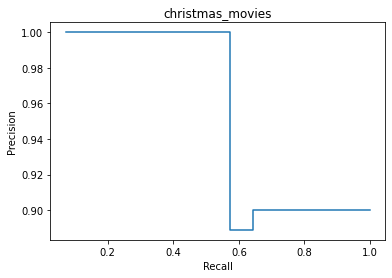

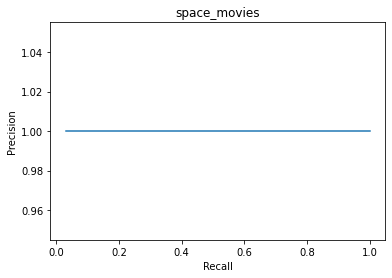

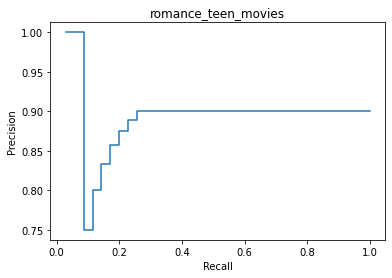

In [26]:
for movie_type in info.keys():
  # Read qrels to extract relevant documents
  relevant = list(map(lambda el: el.strip(), open(info[movie_type]['qrels_file']).readlines()))
  # Get query results from Solr instance
  results = requests.get(info[movie_type]['query_url']).json()["response"]["docs"]
  # Define metrics to be calculated
  evaluation_metrics = {"ap": "Average Precision", "p10": "Precision at 10 (P@10)"}

  # Calculate all metrics and export results as LaTeX table
  df = pd.DataFrame(
      [["Metric", "Value"]]
      + [
          [evaluation_metrics[m], calculate_metric(m, results, relevant)]
          for m in evaluation_metrics
      ]
  )

  with open(f"../results/{movie_type}_results.tex", "w") as tf:
      tf.write(df.to_latex())

    # PRECISION-RECALL CURVE
    # Calculate precision and recall values as we move down the ranked list
  precision_values = [
        len([doc for doc in results[:idx] if doc["tconst"][0] in relevant]) / idx
        for idx, _ in enumerate(results, start=1)
    ]

  recall_values = [
        len([doc for doc in results[:idx] if doc["tconst"][0] in relevant]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]

  precision_recall_match = {k: v for k, v in zip(recall_values, precision_values)}

    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
  recall_values.extend(
        [step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values]
    )
  recall_values = sorted(set(recall_values))

    # Extend matching dict to include these new intermediate steps
  for idx, step in enumerate(recall_values):
        if step not in precision_recall_match:
            if recall_values[idx - 1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[
                    recall_values[idx - 1]
                ]
            else:
                precision_recall_match[step] = precision_recall_match[
                    recall_values[idx + 1]
                ]

  disp = PrecisionRecallDisplay(
        [precision_recall_match.get(r) for r in recall_values], recall_values
    )
  disp.plot()
  plt.title(movie_type)
  plt.savefig(f"../results/{movie_type}_precision_recall.pdf")
